In [0]:
import pandas as pd
import csv
import string
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
import nltk
import keras
from keras.layers import GlobalAveragePooling1D
from nltk.corpus import stopwords
import re 
from keras.callbacks import EarlyStopping
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

def read_file(path):
  dataset = []
  with open(path) as csvfile:
      file = csv.reader(csvfile, delimiter='\t')
      next(file)
      for row in file:
        dataset.append(row)
  return dataset

df_pre = pd.DataFrame(read_file('/content/olid-training-v1.0.tsv'), 
                      columns = ['ID', 'tweet', 'A', 'B', 'C'])
df_pre['Combined'] = df_pre['A']+'-' + df_pre['B'] +'-'+df_pre['C']
multilabels = {lab:ind for ind, lab in enumerate(set(df_pre['Combined'].values.tolist()))}
print('multilabel guide:', multilabels)

levela= pd.read_csv('/content/testset-levela.tsv',  sep='\t')
levelb =pd.read_csv('/content/testset-levelb.tsv', sep='\t')
levelc = pd.read_csv('/content/testset-levelc.tsv', sep='\t')

levela_labels=pd.read_csv('/content/labels-levela.csv', names=['id', 'A'])
levelb_labels=pd.read_csv('/content/labels-levelb.csv',  names=['id', 'B'])
levelc_labels=pd.read_csv('/content/labels-levelc.csv', names=['id', 'C'])

Alevel = pd.merge(levela, levela_labels, on='id')
Blevel = pd.merge(levelb, levelb_labels, on='id')
Clevel = pd.merge(levelc, levelc_labels, on='id')

categorical_test = pd.merge(left=Alevel, right=Blevel, how='left', on=['id', 'tweet'])
categorical_test = pd.merge(left=categorical_test, right=Clevel, how='left', on=['id', 'tweet'])
categorical_test = categorical_test.fillna('NULL')
categorical_test['Combined'] = categorical_test['A']+'-' + categorical_test['B'] +'-'+categorical_test['C']
for ind, row in categorical_test.iterrows():
  categorical_test['Combined'][ind] = multilabels[row.Combined]

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

def preprocess(word_string, emojy = False):
  if emojy==False:
    word_string = deEmojify(word_string)
  lower_words = text_to_word_sequence(word_string, filters=string.punctuation, lower = False, split=' ')
  Fsentences = [] 
  for word in lower_words:
    words = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', word)).split() 
    for w in words:
      if w not in stop_words and not w.isdigit():
        Fsentences.append(w.lower())
  length = len(Fsentences)
  return Fsentences, length



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
multilabel guide: {'OFF-TIN-OTH': 0, 'OFF-TIN-IND': 1, 'OFF-TIN-GRP': 2, 'OFF-UNT-NULL': 3, 'NOT-NULL-NULL': 4}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Level A label guide: 0 - OFF, 1 -NOT

## Preprocessing of Text Training data

In [0]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, MultiLabelBinarizer
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
'''
Preprocessing of tweets and finding number of tokens in longest tweet
'''
def preprocessing_execution(df_pre, emojy=False):
  max_length = 0
  for ind, row in df_pre.iterrows():
    df_pre['tweet'].iloc[ind],length= preprocess(row.tweet, emojy)
    if length >max_length:
      max_length=length 
  return df_pre, max_length

df_pre, max_length = preprocessing_execution(df_pre, emojy=False)
Alevel, _ = preprocessing_execution(Alevel, emojy=False)
categorical_test,_ = preprocessing_execution(categorical_test, emojy=False)


'''
converting string categorical labels to numerical values
'''

def encode_labels(cols, df):
  for col in cols:
    labels = df.pop(col)
    label_set = set(labels.values)
    label_set_ids = {lab: id for id, lab in enumerate(label_set)}
    final_labels = [label_set_ids[lab] for lab in labels]
    df[col] = final_labels
  return df 

Alevel = encode_labels(['A'],Alevel)
df_pre = encode_labels(['A'], df_pre)
df_pre = encode_labels(['Combined'], df_pre)

le = LabelEncoder()
lb = LabelBinarizer()
lb.fit(range(max(Alevel['A'].values.tolist())+1))
Alevel['A'] = lb.transform(Alevel['A'])
df_pre = encode_labels(['Combined'], df_pre)
categorical_test_df = encode_labels(['Combined'], categorical_test)

'''
Creating a dictionary for the vocabulary to be used for word embedding
'''
text=df_pre['tweet'].values
vocab = []
for tweet in text:
  for word in tweet:
    vocab.append(word)
vocab = set(vocab)
vocab_dict = {}
for ind, word in enumerate(vocab):
  vocab_dict[word] = ind+2

#Reserving Tokens for special purposes
vocab_dict["<PAD>"] = 0 
vocab_dict["<UNK>"] = 1  
vocab_dict["<UNUSED>"] = 2

embedded_tweets=[]
for tweet in text:
  tw = []
  for word in tweet:
    tw.append(vocab_dict[word])
  embedded_tweets.append(tw)
df_pre['tweet'] = embedded_tweets

def test_embeddings(df, vocab_dict):
  embeddings =[]
  for tweet in df['tweet'].values:
    tw = []
    for token in tweet:
      if token not in list(vocab_dict.keys()):
        tw.append(vocab_dict["<UNK>"])
      else:
        tw.append(vocab_dict[token])
    embeddings.append(tw)
  return embeddings

levela_test = test_embeddings(Alevel, vocab_dict)
categorical_test = test_embeddings(categorical_test, vocab_dict)


EMBED_SIZE=max_length*2
data_train = pad_sequences(df_pre['tweet'].values, maxlen=EMBED_SIZE)
A_test = pad_sequences(levela_test, maxlen=EMBED_SIZE)
Categorical_test = pad_sequences(categorical_test, maxlen=EMBED_SIZE)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
Xtrain, Ytrain = data_train, df_pre.A.values
Ytest =Alevel.A.values.tolist()

# Level A


### Setting of a Baseline using a linear Support Vector Machine (SVM) - Level A


In [0]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
svm_classifier = SVC()
svm_classifier.fit(Xtrain[:int(len(Xtrain)*0.8)], Ytrain[:int(len(Ytrain)*0.8)])
#train_hat = svm_classifier.predict(data_train)
test_hat = svm_classifier.predict(A_test)
print('Test: \n')
print(classification_report(Ytest, test_hat))


Test: 

              precision    recall  f1-score   support

           0       0.72      1.00      0.84       620
           1       1.00      0.00      0.01       240

    accuracy                           0.72       860
   macro avg       0.86      0.50      0.42       860
weighted avg       0.80      0.72      0.61       860



### Model 1: Embedding and Global Pooling layers 

---

(Part C)

In [0]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

VOCAB_SIZE = len(vocab_dict.items())
def Embedding_pooling_model():
  model=keras.Sequential()
  model.add(keras.layers.Embedding(VOCAB_SIZE, 100, input_length=EMBED_SIZE))
  model.add(GlobalAveragePooling1DMasked())
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
  return model
embedding_modelA = Embedding_pooling_model()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 162, 100)          1821800   
_________________________________________________________________
global_average_pooling1d_mas (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,821,901
Trainable params: 1,821,901
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
cb = EarlyStopping(monitor='val_acc', mode='auto', patience=5)
history1 = embedding_modelA.fit(Xtrain, Ytrain, epochs=20,
                                validation_split=0.2, batch_size=32,
                                verbose=1, workers = 3, use_multiprocessing=True, callbacks=[cb])




Train on 10592 samples, validate on 2648 samples
Epoch 1/20





10592/10592 [==============================] - 11s 1ms/step - loss: 0.6371 - acc: 0.6674 - val_loss: 0.6304 - val_acc: 0.6688
Epoch 2/20
10592/10592 [==============================] - 2s 201us/step - loss: 0.6273 - acc: 0.6674 - val_loss: 0.6241 - val_acc: 0.6688
Epoch 3/20
10592/10592 [==============================] - 2s 200us/step - loss: 0.6156 - acc: 0.6674 - val_loss: 0.6132 - val_acc: 0.6688
Epoch 4/20
10592/10592 [==============================] - 2s 191us/step - loss: 0.5943 - acc: 0.6712 - val_loss: 0.5979 - val_acc: 0.6764
Epoch 5/20
10592/10592 [==============================] - 2s 193us/step - loss: 0.5633 - acc: 0.6964 - val_loss: 0.5786 - val_acc: 0.6922
Epoch 6/20
10592/10592 [==============================] - 2s 191us/step - loss: 0.5259 - acc: 0.7352 - val_loss: 0.5610 - val_acc: 0.7134
Epoch 7/20
10592/10592 [==============================] - 2s 196us/step - loss: 0.4866 - acc: 0.7723 - val_loss: 0.5

In [0]:
print('Test: \n')
test_hat = [round(x[0], 0) for x in embedding_modelA.predict(A_test)]
print(classification_report(Ytest, test_hat))


Test: 

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       620
           1       0.62      0.51      0.56       240

    accuracy                           0.78       860
   macro avg       0.72      0.69      0.70       860
weighted avg       0.77      0.78      0.77       860



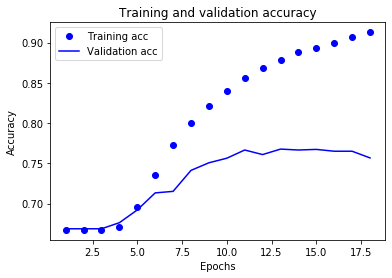

In [0]:
import matplotlib.pyplot as plt

def plotting_history(history):
  history_dict = history.history
  acc = history_dict['acc']
  val_acc = history_dict['val_acc']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

plotting_history(history1)

#### Embedding and Global Pooling with additional layer

In [0]:
def Embedding_pooling_model_additional(act):
  model=keras.Sequential()
  model.add(keras.layers.Embedding(VOCAB_SIZE, 100, input_length=EMBED_SIZE))
  model.add(GlobalAveragePooling1DMasked())
  model.add(keras.layers.Dense(16, activation=act))
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
  return model
embedding_model1R = Embedding_pooling_model_additional('relu')
cb = EarlyStopping(monitor='val_acc', mode='auto', patience=5)
historyR1 = embedding_model1R.fit(Xtrain, Ytrain, epochs=20,
                                validation_split=0.2, batch_size=32,
                                verbose=1, workers = 3, use_multiprocessing=True, callbacks=[cb])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 162, 100)          1821800   
_________________________________________________________________
global_average_pooling1d_mas (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,823,433
Trainable params: 1,823,433
Non-trainable params: 0
_________________________________________________________________
Train on 10592 samples, validate on 2648 samples
Epoch 1/20
10592/10592 [==============================] - 3s 238us/step - loss: 0.6383 - acc: 0.6634 - val_loss: 0.6305 - val_acc: 0.6688
Epoch 2/20
10592/10592 [==============================]

In [0]:
print('Test: \n')
test_hat = [round(x[0], 0) for x in embedding_model1R.predict(A_test)]
print(classification_report(Ytest, test_hat))

Test: 

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       620
           1       0.58      0.54      0.56       240

    accuracy                           0.76       860
   macro avg       0.71      0.69      0.70       860
weighted avg       0.76      0.76      0.76       860



In [0]:
embedding_model1T = Embedding_pooling_model_additional('tanh')
cb = EarlyStopping(monitor='val_acc', mode='auto', patience=5)
historyT1 = embedding_model1T.fit(Xtrain, Ytrain, epochs=20,
                                validation_split=0.2, batch_size=32,
                                verbose=1, workers = 3, use_multiprocessing=True, callbacks=[cb])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 162, 100)          1821800   
_________________________________________________________________
global_average_pooling1d_mas (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,823,433
Trainable params: 1,823,433
Non-trainable params: 0
_________________________________________________________________
Train on 10592 samples, validate on 2648 samples
Epoch 1/20
10592/10592 [==============================] - 3s 243us/step - loss: 0.6346 - acc: 0.6674 - val_loss: 0.6300 - val_acc: 0.6688
Epoch 2/20
10592/10592 [==============================]

In [0]:
print('Test: \n')
test_hat = [round(x[0], 0) for x in embedding_model1T.predict(A_test)]
print(classification_report(Ytest, test_hat))

Test: 

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       620
           1       0.58      0.50      0.54       240

    accuracy                           0.76       860
   macro avg       0.70      0.68      0.69       860
weighted avg       0.75      0.76      0.75       860



# Multiclass - combined Levels A, B and C

### Baseline

In [0]:
Xtrain, Ytrain = data_train, df_pre.Combined.values
Ytest =categorical_test_df['Combined'].values.tolist()
svm_classifier = SVC()
svm_classifier.fit(data_train[:int(len(data_train)*0.8)], Ytrain[:int(len(Ytrain)*0.8)])
test_hat = svm_classifier.predict(Categorical_test)
print('Test: \n')
print(classification_report(Ytest, test_hat))


Test: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00        78
           3       0.00      0.00      0.00        27
           4       0.72      1.00      0.84       620

    accuracy                           0.72       860
   macro avg       0.14      0.20      0.17       860
weighted avg       0.52      0.72      0.60       860



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Multiclass - Embedding pooling model

In [0]:
def Embedding_pooling_model_multiclass():

  cb = EarlyStopping(monitor='val_acc', mode='auto', patience=15)
  model=keras.Sequential()
  model.add(keras.layers.Embedding(VOCAB_SIZE, 100, input_length=EMBED_SIZE))
  model.add(GlobalAveragePooling1DMasked())
  model.add(keras.layers.Dense(16, activation='relu'))
  model.add(keras.layers.Dense(5, activation='softmax'))
  model.summary()
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model
embedding_model_multiclass = Embedding_pooling_model_multiclass()
class_weight = {0: 6.2,
                1: 22.97,
                2: 7.95, 
                3: 17.7, 
                4: 1}

history3 = embedding_model_multiclass.fit(Xtrain,Ytrain,epochs=100,
                                          validation_split=0.2, batch_size=32, class_weight=class_weight,
                                          verbose=1,workers = 3, use_multiprocessing=True)#, callbacks = [cb])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 162, 100)          1821800   
_________________________________________________________________
global_average_pooling1d_mas (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 85        
Total params: 1,823,501
Trainable params: 1,823,501
Non-trainable params: 0
_________________________________________________________________
Train on 10592 samples, validate on 2648 samples
Epoch 1/100
10592/10592 [==============================] - 2s 229us/step - loss: 7.3234 - acc: 0.1812 - val_loss: 6.8871 - val_acc: 0.1805
Epoch 2/100
10592/10592 [=============================

In [0]:
import numpy as np
print(classification_report(Ytest, np.argmax(embedding_model_multiclass.predict(Categorical_test), axis =1)))

              precision    recall  f1-score   support

           0       0.14      0.09      0.11        35
           1       0.30      0.31      0.30       100
           2       0.16      0.12      0.13        78
           3       0.19      0.26      0.22        27
           4       0.79      0.82      0.80       620

    accuracy                           0.65       860
   macro avg       0.31      0.32      0.31       860
weighted avg       0.63      0.65      0.64       860



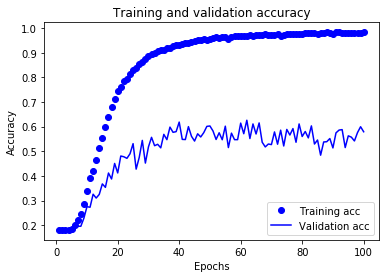

In [0]:
class_weight = {0: 20,
                1: 2,
                2: 1.5, 
                3: 18, 
                4: 1}
plotting_history(history3)

### Additional model architectures

#### Convolutional NN

In [0]:
cb = EarlyStopping(monitor='val_acc', mode='auto', patience=5)
def Conv_Model():
  Num_filters =3
  Filter_width=6
  cb = EarlyStopping(monitor='val_acc', mode='auto', patience=5)
  model=keras.Sequential()
  model.add(keras.layers.Embedding(VOCAB_SIZE, 100, input_length=EMBED_SIZE))
  model.add(keras.layers.Conv1D(Num_filters, kernel_size=Filter_width, activation='relu'))
  model.add(GlobalAveragePooling1DMasked())
  #model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(5, activation='softmax'))
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model
conv_model = Conv_Model()
conv_hist = conv_model.fit(Xtrain,Ytrain,epochs=20, validation_split=0.2, 
                           batch_size=32,verbose=1,workers = 3, 
                           use_multiprocessing=True, callbacks = [cb])
print(classification_report(Ytest, np.argmax(conv_model.predict(Categorical_test), axis =1)))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 162, 100)          1821800   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 157, 3)            1803      
_________________________________________________________________
global_average_pooling1d_mas (None, 3)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 20        
Total params: 1,823,623
Trainable params: 1,823,623
Non-trainable params: 0
_________________________________________________________________
Train on 10592 samples, validate on 2648 samples
Epoch 1/20
10592/10592 [==============================] - 3s 323us/step - loss: 1.2273 - acc: 0.4515 - val_loss: 1.0187 - val_acc: 0.6688
Epoch 2/20
10592/10592 [==============================]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Embedding-Pooling (increased_depth)

In [0]:
def Embedding_pooling_model_multiclass_extra_layer():
  cb = EarlyStopping(monitor='val_acc', mode='auto', patience=5)
  model=keras.Sequential()
  model.add(keras.layers.Embedding(VOCAB_SIZE, 100, input_length=EMBED_SIZE))
  model.add(GlobalAveragePooling1DMasked())
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(128, activation='relu'))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dense(16, activation='relu'))
  model.add(keras.layers.Dense(5, activation='softmax'))
  model.summary()
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model
embedding_pooling_model_multiclass_extra_layer = Embedding_pooling_model_multiclass_extra_layer()
history4 = embedding_pooling_model_multiclass_extra_layer.fit(Xtrain,Ytrain,epochs=20,
                                                              validation_split=0.2, batch_size=32,
                                                              verbose=1,workers = 3, use_multiprocessing=True, callbacks = [cb])
print(classification_report(Ytest, np.argmax(embedding_pooling_model_multiclass_extra_layer.predict(Categorical_test), axis =1)))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 162, 100)          1821800   
_________________________________________________________________
global_average_pooling1d_mas (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_13 (Dense)             (None, 5)                

#### Seperate models into pipeline

In [0]:
from keras.utils import plot_model
def pipeline_model():
  inputA = keras.layers.Input((EMBED_SIZE,), dtype='float32', name='inputA')
  modelA_hidden1 = keras.layers.Dense(648, activation='relu', name='modelA_hidden1')(inputA)
  outputA = keras.layers.Dense(1, activation='sigmoid', name='outputA')(modelA_hidden1)

  inputB = keras.layers.Input((EMBED_SIZE,), dtype='float32', name='inputB')
  modelB_hidden1 = keras.layers.Dense(648, activation='relu', name='modelB_hidden1')(inputB)
  outputB = keras.layers.Dense(3, activation='softmax', name='outputB')(modelB_hidden1)

  inputC = keras.layers.Input((EMBED_SIZE,), dtype='float32', name='inputC')
  modelC_hidden1 = keras.layers.Dense(648, activation='relu', name='modelC_hidden1')(inputC)
  outputC = keras.layers.Dense(4, activation='softmax', name='outputC')(modelC_hidden1)

  final_input = keras.layers.concatenate([outputA, outputB, outputC], name = 'IndividualConcat')
  final_model_1 = keras.layers.Dense(10, activation='relu', name='Final_Model_1')(final_input)
  final_model_2 = keras.layers.Dense(128, activation='relu', name='Final_Model_2')(final_model_1)
  final_output = keras.layers.Dense(5, activation='softmax', name='Final_Output')(final_model_2)

  model= keras.Model(inputs=[inputA, inputB, inputC], output=[final_output])
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  #plot_model(model, to_file='model.png')
  model.summary()
  return model
pipeline_model = pipeline_model()
pipeline_history = pipeline_model.fit([Xtrain, Xtrain, Xtrain],Ytrain,epochs=20, validation_split=0.2, 
                                      batch_size=32,verbose=1,workers = 3, 
                                      use_multiprocessing=True, callbacks = [cb])
print(classification_report(Ytest, np.argmax(pipeline_model.predict([Categorical_test, Categorical_test, Categorical_test]), axis =1)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputA (InputLayer)             (None, 162)          0                                            
__________________________________________________________________________________________________
inputB (InputLayer)             (None, 162)          0                                            
__________________________________________________________________________________________________
inputC (InputLayer)             (None, 162)          0                                            
__________________________________________________________________________________________________
modelA_hidden1 (Dense)          (None, 648)          105624      inputA[0][0]                     
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Glove file embedding model

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
import zipfile
import os
path = 'glove.6B.zip'
directory = os.getcwd()
zipfile_ = zipfile.ZipFile(path, 'r')
zipfile_.extractall(directory)
zipfile_.close()

--2020-02-29 21:44:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-02-29 21:44:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-02-29 21:44:13--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove
  
from keras.initializers import Constant
def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = keras.layers.Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable)
    return embeddingLayer

wordToIndex, indexToWord, wordToGlove = readGloveFile('glove.6B.300d.txt')

In [0]:
def glove_model():
  model_glove = keras.Sequential()
  model_glove.model.add(createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable=True))
  model_glove.add(GlobalAveragePooling1DMasked())
  #model_glove.add(keras.layers.Dense(256, activation='relu'))###
  #model_glove.add(keras.layers.Dense(128, activation='relu'))###
  #model_glove.add(keras.layers.Dense(64, activation='relu'))###
  model_glove.add(keras.layers.Dense(16, activation='relu'))
  model_glove.add(keras.layers.Dense(5, activation='softmax'))
  model_glove.summary()
  model_glove.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
  return model_glove
model_glove = glove_model()

/usr/local/lib/python3.6/dist-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 300)         120000300 
_________________________________________________________________
global_average_pooling1d_mas (None, 300)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)                4816      
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 85        
Total params: 120,005,201
Trainable params: 120,005,201
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 300)         120000300 
_________________________________________________________________
global_average_pooling1d_mas (None, 300)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               77056     
_________________________________________________________________
dense_38 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_39 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_40 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_41 (Dense)             (None, 5)               

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:421: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000300 elements. This may consume a large amount of memory.
  num_elements)


Train on 10592 samples, validate on 2648 samples
Epoch 1/20
10592/10592 [==============================] - 20s 2ms/step - loss: 1.0377 - acc: 0.6649 - val_loss: 0.9870 - val_acc: 0.6688
Epoch 2/20
10592/10592 [==============================] - 14s 1ms/step - loss: 0.9435 - acc: 0.6701 - val_loss: 0.9214 - val_acc: 0.6915
Epoch 3/20
10592/10592 [==============================] - 14s 1ms/step - loss: 0.7594 - acc: 0.7346 - val_loss: 0.9010 - val_acc: 0.7081
Epoch 4/20
10592/10592 [==============================] - 14s 1ms/step - loss: 0.6038 - acc: 0.7902 - val_loss: 0.9880 - val_acc: 0.6869
Epoch 5/20
10592/10592 [==============================] - 14s 1ms/step - loss: 0.4918 - acc: 0.8319 - val_loss: 1.1504 - val_acc: 0.6813
Epoch 6/20
10592/10592 [==============================] - 14s 1ms/step - loss: 0.4147 - acc: 0.8532 - val_loss: 1.2179 - val_acc: 0.6677
Epoch 7/20
10592/10592 [==============================] - 14s 1ms/step - loss: 0.3460 - acc: 0.8799 - val_loss: 1.3866 - val_acc:

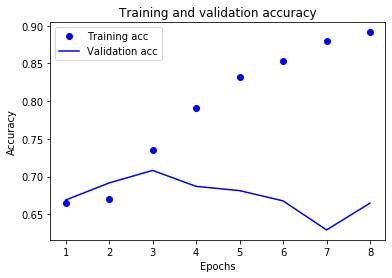

In [0]:

cb = EarlyStopping(monitor='val_acc', mode='auto', patience=5)
glove_history = model_glove.fit(Xtrain,Ytrain,epochs=20,
                                validation_split=0.2, batch_size=32,
                                verbose=1,workers = 3, use_multiprocessing=True, callbacks = [cb])
plotting_history(glove_history)

In [0]:
print(classification_report(Ytest, np.argmax(model_glove.predict(Categorical_test), axis =1)))

              precision    recall  f1-score   support

           0       0.37      0.37      0.37       100
           1       0.20      0.04      0.06        27
           2       0.30      0.17      0.21        78
           3       0.09      0.03      0.04        35
           4       0.81      0.91      0.86       620

    accuracy                           0.72       860
   macro avg       0.35      0.30      0.31       860
weighted avg       0.66      0.72      0.68       860



#### LSTM Model


In [0]:
def LSTM_model():
  model=keras.Sequential()
  model.add(keras.layers.Embedding(VOCAB_SIZE, 100, input_length=EMBED_SIZE))
  #model.add(GlobalAveragePooling1DMasked())
  model.add(keras.layers.LSTM(126))
  model.add(keras.layers.Dense(5, activation='softmax'))
  model.summary()
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model
lstm_model = LSTM_model()
lstm_history = lstm_model.fit(Xtrain,Ytrain,epochs=20,
                              validation_split=0.2, batch_size=32,
                              verbose=1,workers = 3, use_multiprocessing=True, callbacks = [cb])

print(classification_report(Ytest, np.argmax(lstm_model.predict(Categorical_test), axis =1)))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 162, 100)          1821800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 126)               114408    
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 635       
Total params: 1,936,843
Trainable params: 1,936,843
Non-trainable params: 0
_________________________________________________________________
Train on 10592 samples, validate on 2648 samples
Epoch 1/20
10592/10592 [==============================] - 87s 8ms/step - loss: 0.9726 - acc: 0.6781 - val_loss: 0.8794 - val_acc: 0.7028
Epoch 2/20
10592/10592 [==============================] - 86s 8ms/step - loss: 0.6939 - acc: 0.7610 - val_loss: 0.9348 - val_acc: 0.7062
Epoch 3/20
10592/10592 [===========================

#### Bidirectional LSTM

In [0]:
from keras.layers import Bidirectional
def LSTM_Bidirectional_model():
  model=keras.Sequential()
  model.add(keras.layers.Embedding(VOCAB_SIZE, 100, input_length=EMBED_SIZE))
  #model.add(GlobalAveragePooling1DMasked())
  model.add(Bidirectional(keras.layers.LSTM(EMBED_SIZE)))
  model.add(keras.layers.Dense(5, activation='softmax'))
  model.summary()
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model
Bilstm_model = LSTM_Bidirectional_model()
Bilstm_history = Bilstm_model.fit(Xtrain,Ytrain,epochs=20,
                              validation_split=0.2, batch_size=32,
                              verbose=1,workers = 3, use_multiprocessing=True, callbacks = [cb])

print(classification_report(Ytest, np.argmax(Bilstm_model.predict(Categorical_test), axis =1)))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 162, 100)          1821800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 324)               340848    
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 1625      
Total params: 2,164,273
Trainable params: 2,164,273
Non-trainable params: 0
_________________________________________________________________
Train on 10592 samples, validate on 2648 samples
Epoch 1/20
10592/10592 [==============================] - 190s 18ms/step - loss: 0.9593 - acc: 0.6825 - val_loss: 0.8711 - val_acc: 0.7081
Epoch 2/20
10592/10592 [==============================] - 189s 18ms/step - loss: 0.6953 - acc: 0.7635 - val_loss: 0.9125 - val_acc: 0.7017
Epoch 3/20
10592/10592 [=======================